## Assignment 1

* This first assignment consists of doing an end to end project with the MAGIC Gamma Telescope dataset.
The data are MC generated to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background).

Typically, the image of a shower after some pre-processing is an elongated cluster. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. If the depositions were distributed as a bivariate Gaussian, this would be an equidensity ellipse. The characteristic parameters of this ellipse (often called Hillas parameters) are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions.

## Attribute Information:

1. fLength: continuous # major axis of ellipse [mm]
2. fWidth: continuous # minor axis of ellipse [mm]
3. fSize: continuous # 10-log of sum of content of all pixels [in #phot]
4. fConc: continuous # ratio of sum of two highest pixels over fSize [ratio]
5. fConc1: continuous # ratio of highest pixel over fSize [ratio]
6. fAsym: continuous # distance from highest pixel to center, projected onto major axis [mm]
7. fM3Long: continuous # 3rd root of third moment along major axis [mm]
8. fM3Trans: continuous # 3rd root of third moment along minor axis [mm]
9. fAlpha: continuous # angle of major axis with vector to origin [deg]
10. fDist: continuous # distance from origin to center of ellipse [mm]
11. class: g,h # gamma (signal), hadron (background)

g = gamma (signal): 12332
h = hadron (background): 6688

For technical reasons, the number of h events is underestimated. In the real data, the h class represents the majority of the events.

The simple classification accuracy is not meaningful for this data, since classifying a background event as signal is worse than classifying a signal event as background. For comparison of different classifiers an ROC curve has to be used. The relevant points on this curve are those, where the probability of accepting a background event as signal is below one of the following thresholds: 0.01, 0.02, 0.05, 0.1, 0.2 depending on the required quality of the sample of the accepted events for different experiments.

## Things to do:
* Inspect the data following the guidelines.
* Scale the data with the Standard Scaler. This will require that you remove the non numerical `class` atribute and then you reinstate it.
* Split the sample into training and validation subsamples.
    * Make sure and show that the training and validation subsamples are stratified.
* Plot the variables for the signal ('g') and background ('h') in a single plot.
* Make a scatter plot of the `fLength` and `fWidth` variables for signal and background.
* Train a linear model and measure its RMSE and Mean Absolute Error
* Train a DecisionTreeRegressor and measure its RMSE and Mean Absolute Error
* Perform a cross validaton and estimate the mean RMSE
* Evaluate the models on the Test Set.

# Make the major imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Get the Data

In [2]:
from six.moves import urllib
urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data','./data/magic04.data')

('./data/magic04.data', <http.client.HTTPMessage at 0x123526c10>)

## Convert the data in a Pandas Data Frame

In [3]:
# This reads the data as given by the MAGIC collaboration...
df = pd.read_csv('./data/magic04.data',sep=',', header=None,names=['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist','class'])

In [4]:
df.head()

fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist class  
0  40.0920   81.8828     g  
1   6.3609  205.2610     g  
2  76.9600  256.7880     g  
3  10.4490  116.7370     g  
4   4.6480  356.4620     g

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


### Count how many signal (g) and background (h) events there are in the sample 

In [6]:
vc = df["class"].value_counts()

print("There are {} events ({:.2f}% of the total) labeled as signal.".format(vc[0], 100*vc[0]/(vc[0]+vc[1])))
print("There are {} events ({:.2f}% of the total) labeled as background.".format(vc[1], 100*vc[1]/(vc[0]+vc[1])))

There are 12332 events (64.84% of the total) labeled as signal.
There are 6688 events (35.16% of the total) labeled as background.


### Use the describe method to summarize the numerical atributes

In [7]:
df.describe()

fLength        fWidth         fSize         fConc        fConc1  \
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000   
mean      53.250154     22.180966      2.825017      0.380327      0.214657   
std       42.364855     18.346056      0.472599      0.182813      0.110511   
min        4.283500      0.000000      1.941300      0.013100      0.000300   
25%       24.336000     11.863800      2.477100      0.235800      0.128475   
50%       37.147700     17.139900      2.739600      0.354150      0.196500   
75%       70.122175     24.739475      3.101600      0.503700      0.285225   
max      334.177000    256.382000      5.323300      0.893000      0.675200   

              fAsym       fM3Long      fM3Trans        fAlpha         fDist  
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000  
mean      -4.331745     10.545545      0.249726     27.645707    193.818026  
std       59.206062     51.000118     20.827439     26.103621     74.731787  
min     -457.916100   -331.780000   -205.894700      0.000000      1.282600  
25%      -20.586550    -12.842775    -10.849375      5.547925    142.492250  
50%        4.013050     15.314100      0.666200     17.679500    191.851450  
75%       24.063700     35.837800     10.946425     45.883550    240.563825  
max      575.240700    238.321000    179.851000     90.000000    495.561000

### Create an stratified test set keeping the original signal and background proportions.
### Check that the proportions are kept.
We know that is wrong because the dataset authors set so. But this is an academic exercise.

In [8]:
# We now stratify the data in order to preserve the proportion of signal data and background in 
# the training and test samples

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # n_splits controls the number of splits
# we want to subject the data to, in this case, just one split is enough. Then, we want the test sample to be of the
# 20% of the data. Finally, random_state needs a seed in order to work, 42 is a popular one because of the sci-fi 
# nobel

for train_index, test_index in split.split(df, df["class"]): # Generates the indices of the two sets of data and
    strat_train_set = df.loc[train_index]                    # then create a df fot every set.
    strat_test_set  = df.loc[test_index]

In [9]:
# Now we check the proportion is still the same.

vc_train = strat_train_set["class"].value_counts()
vc_test  = strat_test_set["class"].value_counts()

print("There are {} events ({:.2f}% of the total) labeled as signal in the training set.".format(vc_train[0], 
                                                                             100*vc_train[0]/(vc_train[0]+vc_train[1])))

print("There are {} events ({:.2f}% of the total) labeled as background in the training set.".format(vc_train[1], 
                                                                                 100*vc_train[1]/(vc_train[0]+vc_train[1])))

print(" ")

print("There are {} events ({:.2f}% of the total) labeled as signal in the testing set.".format(vc_test[0], 
                                                                             100*vc_test[0]/(vc_test[0]+vc_test[1])))

print("There are {} events ({:.2f}% of the total) labeled as background in the testing set.".format(vc_test[1], 
                                                                                 100*vc_test[1]/(vc_test[0]+vc_test[1])))

print(" ")
print("We see that the proportion is kept!")

There are 9866 events (64.84% of the total) labeled as signal in the training set.
There are 5350 events (35.16% of the total) labeled as background in the training set.
 
There are 2466 events (64.83% of the total) labeled as signal in the testing set.
There are 1338 events (35.17% of the total) labeled as background in the testing set.
 
We see that the proportion is kept!


### Separate the signal and background samples and show histograms of each variable for both overlaid.
### Remove the `class` feature that is not longer necessary.

In [10]:
# We now separate the training data into signa events and background events, and then remove the "class" variable
# as it is no longer needed

signal_train = strat_train_set[strat_train_set["class"] == "g"].drop("class", axis=1)
bkg_train    = strat_train_set[strat_train_set["class"] == "h"].drop("class", axis=1)

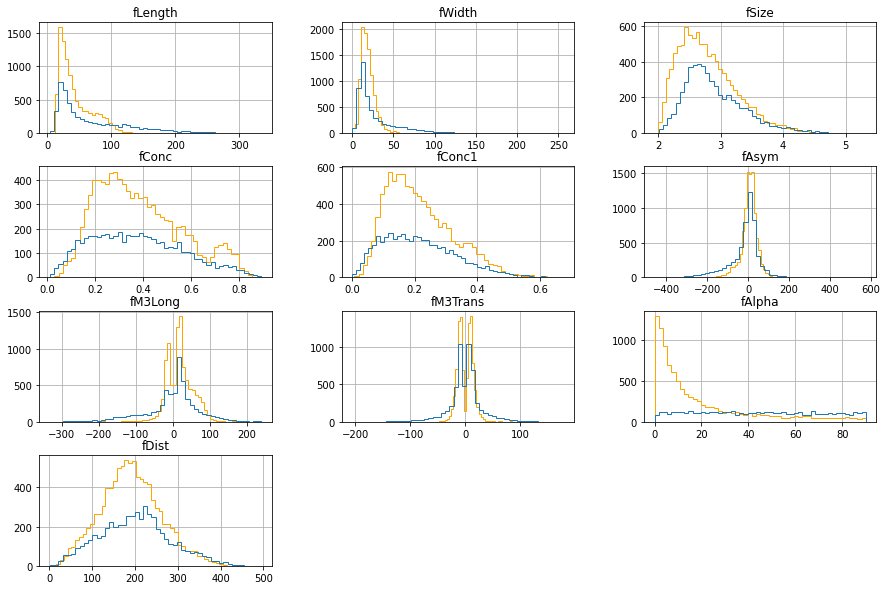

In [11]:
# Now we plot every variable just to make a quick view. Maybe some variables would need a logarithmic scale
# or a closer approach. In this case, I would prefer plotting it in a separate figure for easier customization.

axs = signal_train.hist(figsize=(15,10), bins=50, histtype="step", color="orange", grid="False");
bkg_train.hist(ax=axs.flatten()[0:10], bins=50, histtype="step");

# Flatten method allows us to plot both dataframes in the same figure.

### Make a scatter plot of the `fLength` and `fWidth` variables for signal and background.

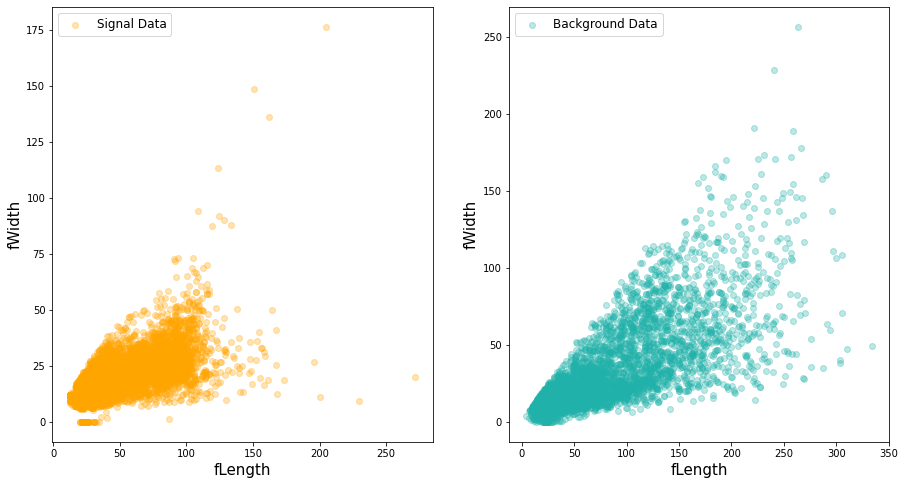

In [12]:
# We use now matplotlib to make a scatter plot of two variables with the background and the signal.

fig  = plt.figure(figsize=(15,8))

ax_s = fig.add_subplot(121)
ax_b = fig.add_subplot(122)

ax_s.scatter(signal_train["fLength"], signal_train["fWidth"], alpha=0.3, c="orange", label="Signal Data");
ax_s.set_xlabel("fLength", fontsize=15);
ax_s.set_ylabel("fWidth", fontsize=15);
ax_s.legend(loc="upper left", fontsize=12);

ax_b.scatter(bkg_train["fLength"], bkg_train["fWidth"], alpha=0.3, c="lightseagreen", label="Background Data");
ax_b.set_xlabel("fLength", fontsize=15);
ax_b.set_ylabel("fWidth", fontsize=15);
ax_b.legend(fontsize=12);

### Check correlations in data with 2d plots of every pair of variables

<Figure size 640x480 with 0 Axes>

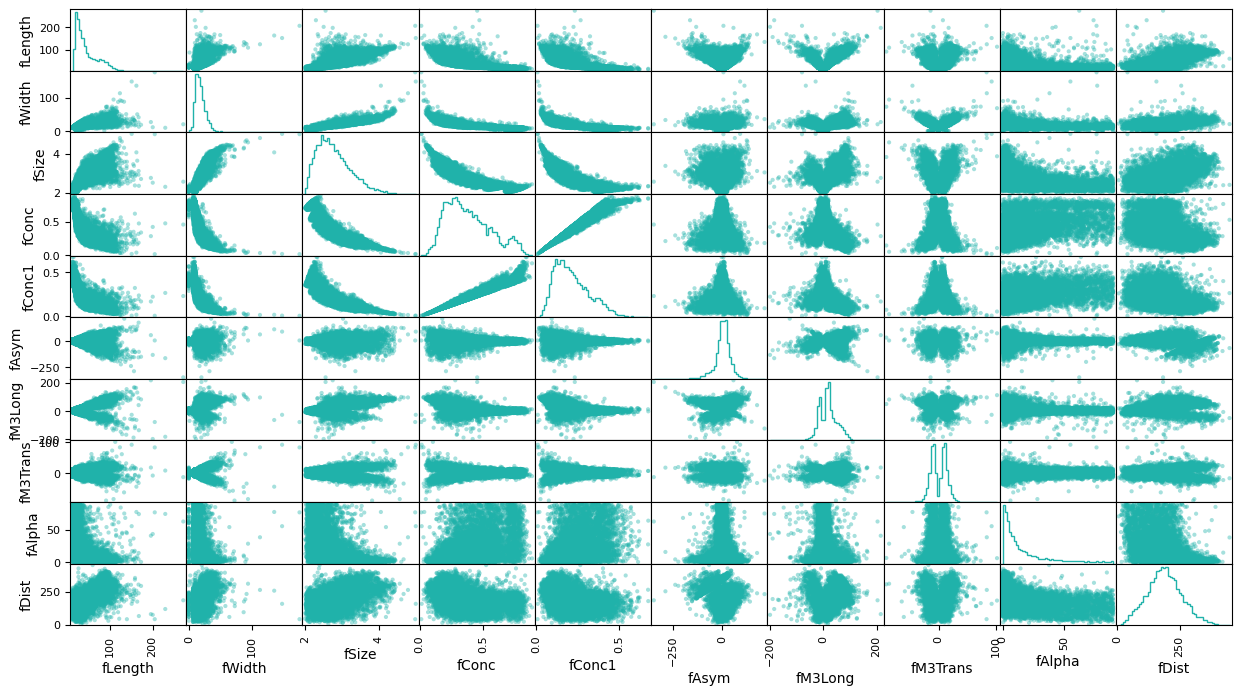

In [13]:
# We here check the correlation for the signal dataset (training set)

plt.style.use('default')
fig = plt.figure();

pd.plotting.scatter_matrix(signal_train, c="lightseagreen", figsize=(15,8), alpha=0.4, 
                           hist_kwds={'histtype':"step", "bins":50, "color":"lightseagreen"});

<Figure size 640x480 with 0 Axes>

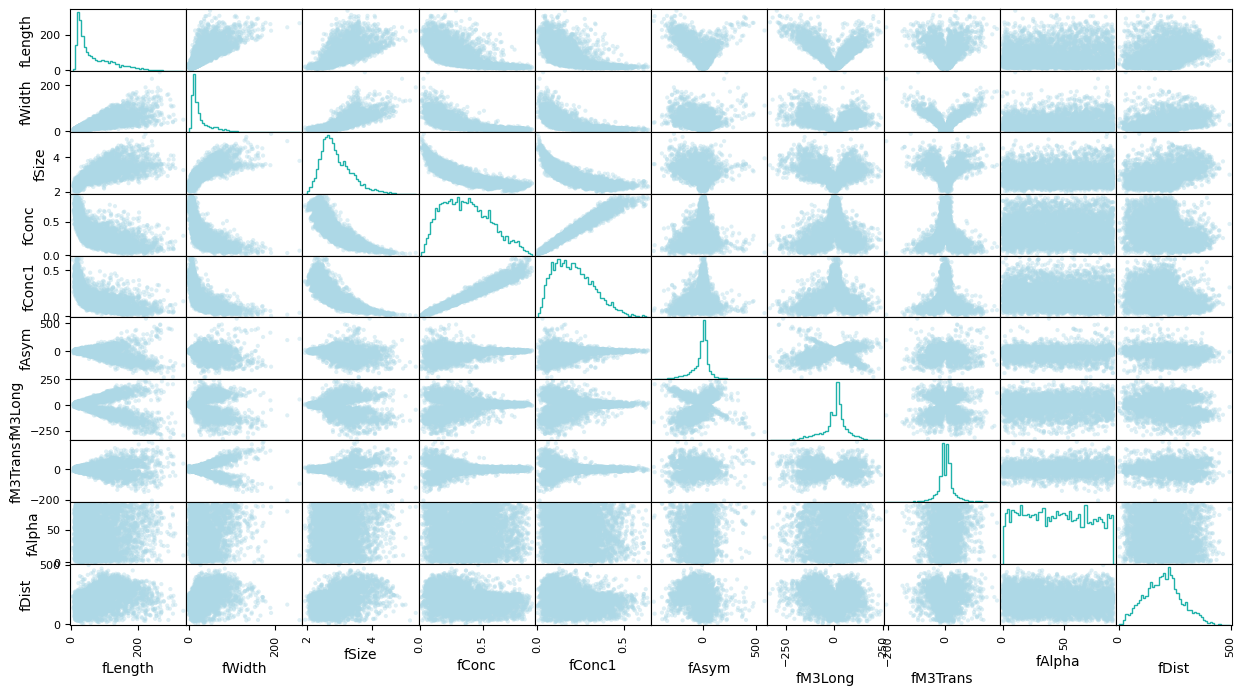

In [14]:
# We here check the correlation for the signal dataset (training set)

plt.style.use('default')
fig = plt.figure();

pd.plotting.scatter_matrix(bkg_train, c="lightblue", figsize=(15,8), alpha=0.4, 
                           hist_kwds={'histtype':"step", "bins":50, "color":"lightseagreen"});

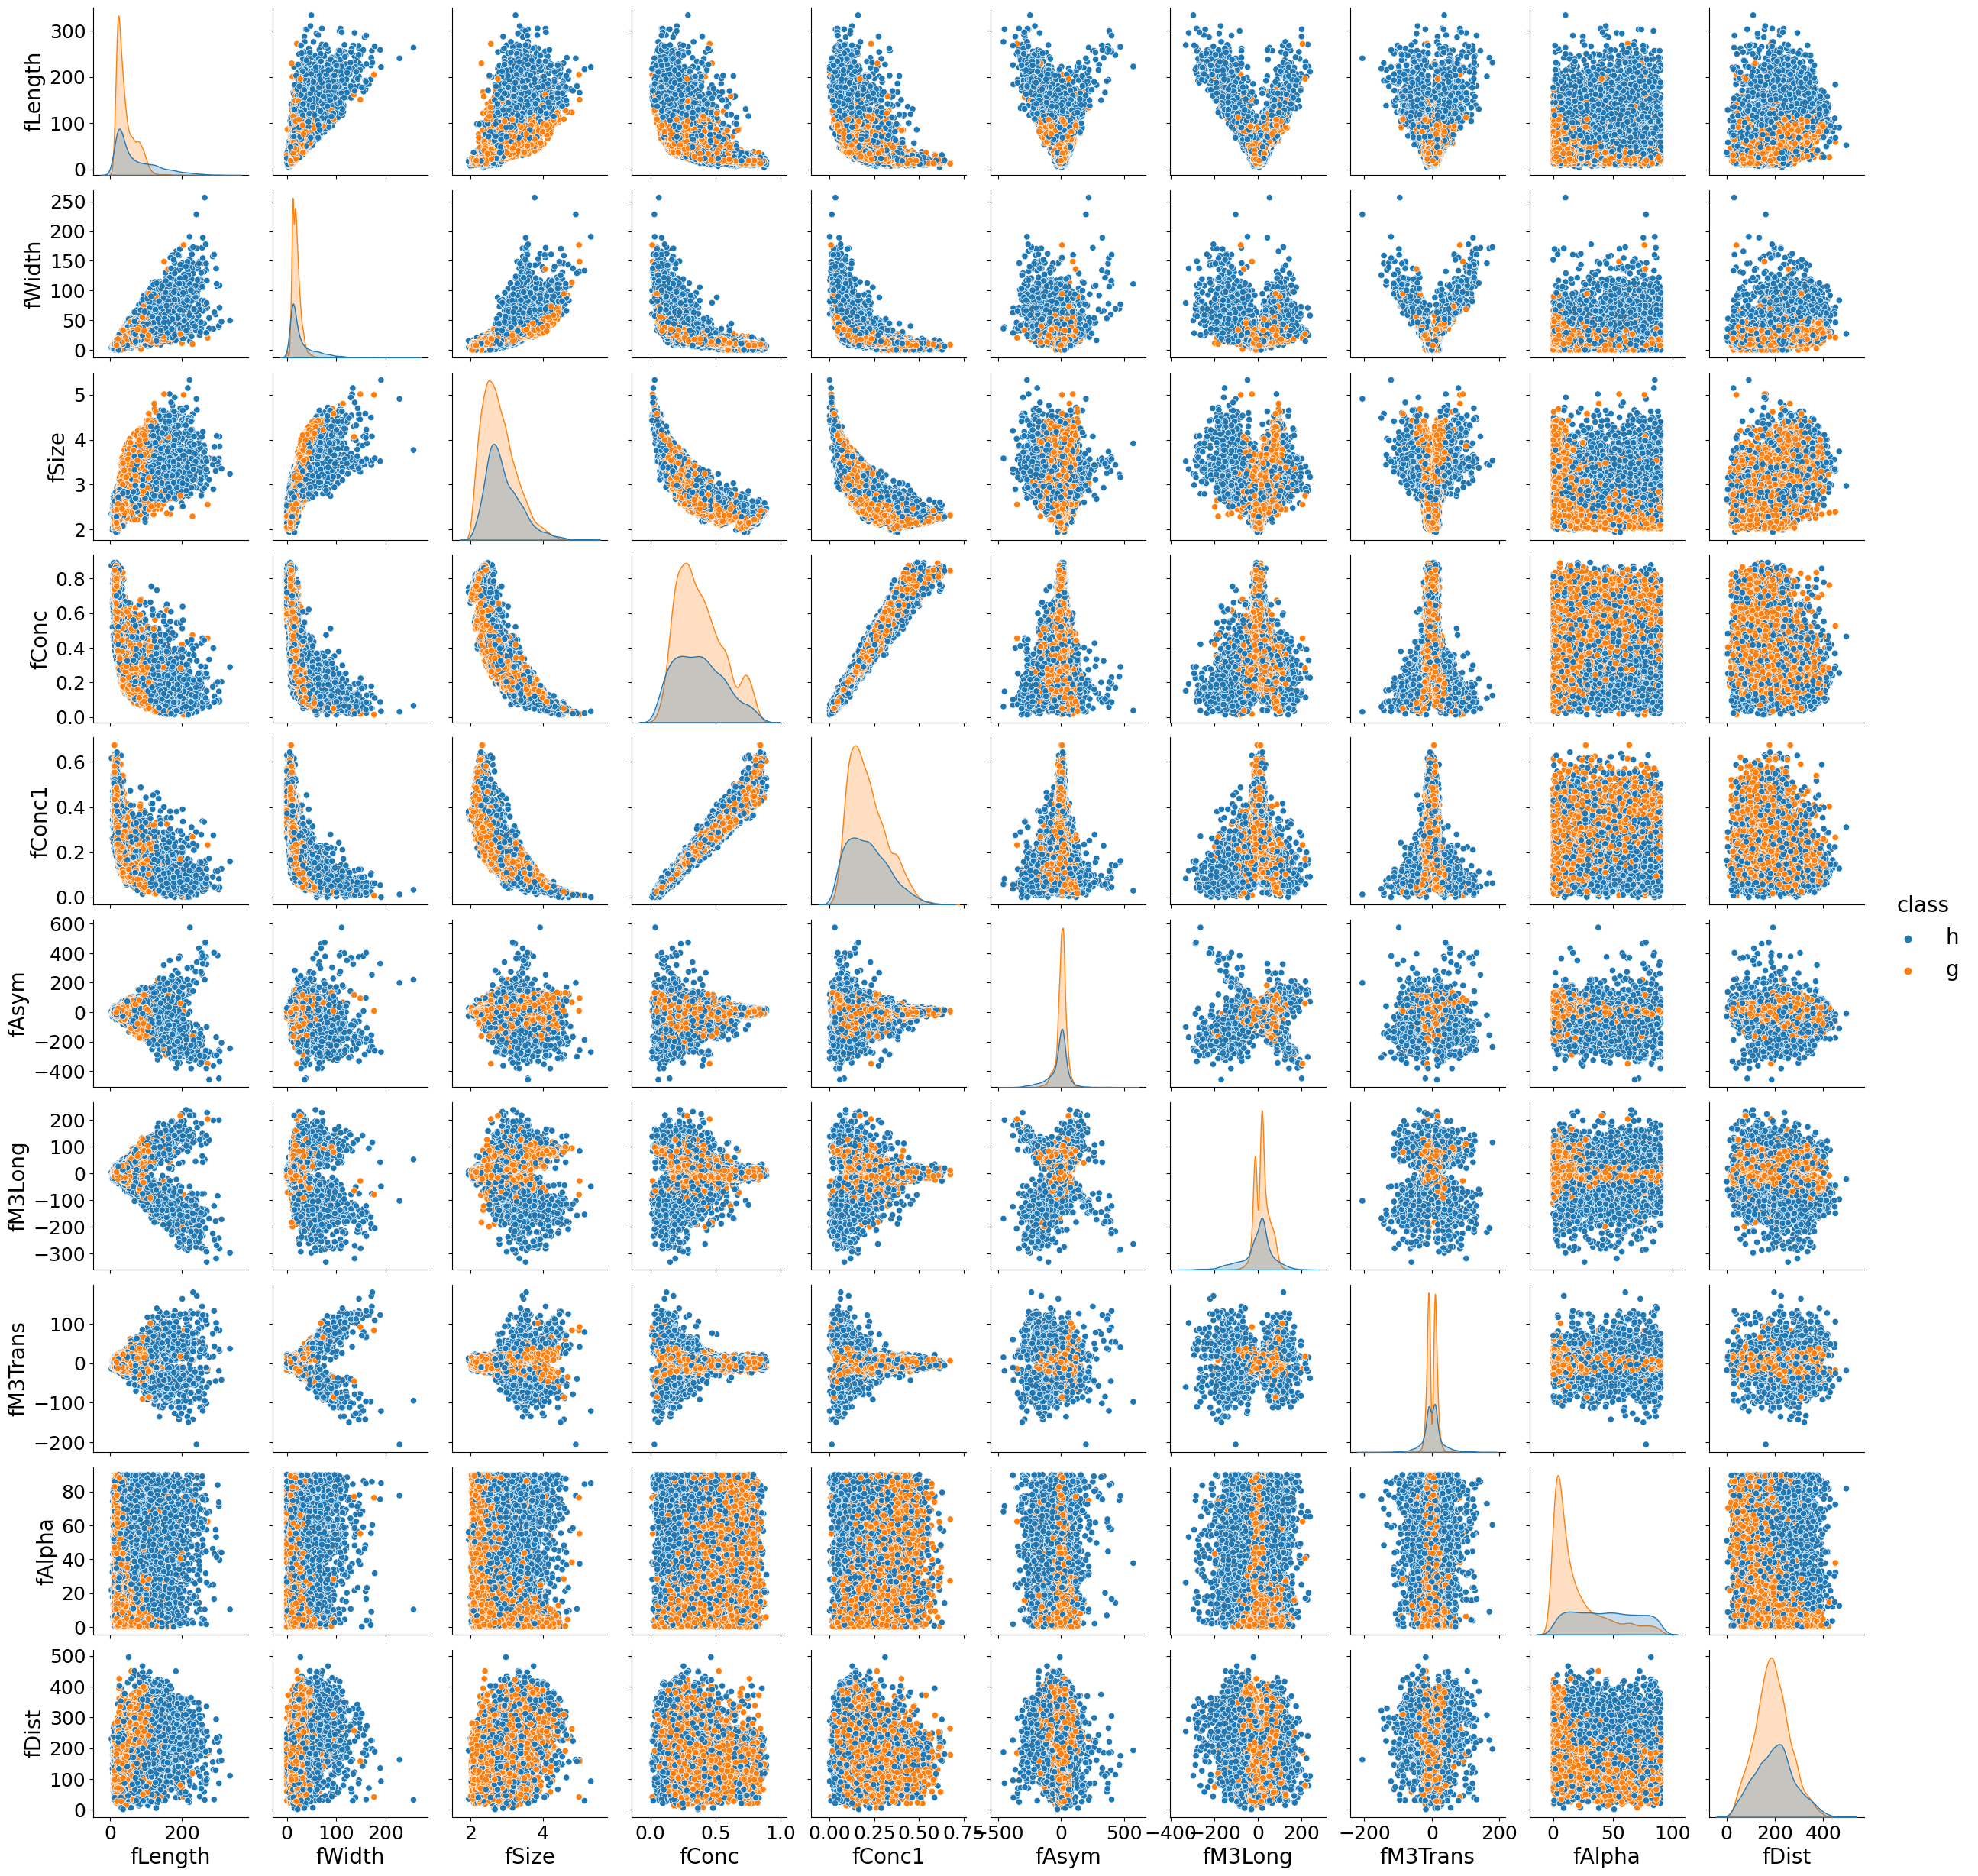

In [15]:
# Nevertheless, we can implement a method given by seaborn library. With this "pairplot" method, we can unify 
# the histogram plots that we made at the beginning and the scatter_matrices in one plot. Maybe with this much 
# variables it is a bit annoying as it works a bit slow.

with sns.plotting_context(rc={"axes.labelsize":20, "xtick.labelsize":18, "ytick.labelsize":18, 
                              'legend.fontsize': 20, 'legend.title_fontsize':20}):
    sns.pairplot(strat_train_set, hue="class")

### Since `fConc` and `fConc1` are strongly correlated remove `fConc1`.

In [16]:
signal_train = signal_train.drop("fConc", axis=1)
bkg_train    = bkg_train.drop("fConc", axis=1)

### Scale the training data with the `StandardScaler`

In [17]:
# We do perform a Standard scaling in the training data: strat_train_set. Take into account you first have to drop 
# the class column as it is non numerical. Then, we perform the same scaling to the test data: strat_test_set.

from sklearn.preprocessing import StandardScaler

scaler       = StandardScaler()
train_non_sc = strat_train_set.drop("class", axis=1)
train_sc_np  = scaler.fit_transform(train_non_sc)
train_sc     = pd.DataFrame(train_sc_np, columns=train_non_sc.columns, index=train_non_sc.index)

test_non_sc  = strat_test_set.drop("class", axis=1)
test_sc_np   = scaler.transform(test_non_sc)
test_sc      = pd.DataFrame(test_sc_np, columns=test_non_sc.columns, index=test_non_sc.index)

# Now we add the column "class"
train_sc["class"] = strat_train_set["class"]
test_sc["class"]  = strat_test_set["class"]

### Repeat the plots with the scaled data.

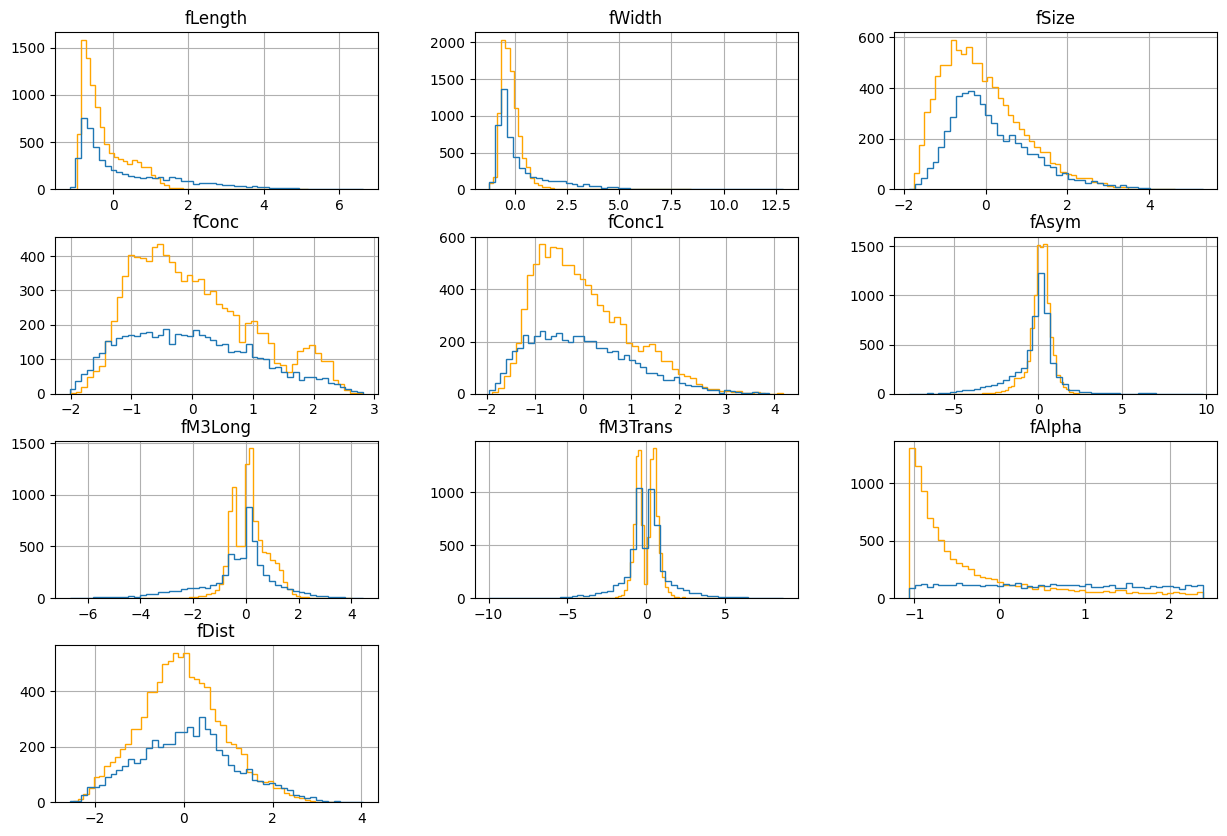

In [18]:
scaled_signal_train = train_sc[train_sc["class"] == "g"] 
scaled_bkg_train    = train_sc[train_sc["class"] == "h"]

axs = scaled_signal_train.hist(figsize=(15,10), bins=50, histtype="step", color="orange", grid="False");
scaled_bkg_train.hist(ax=axs.flatten()[0:10], bins=50, histtype="step");

In [19]:
strat_train_set.head()

fLength   fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
12777   92.0485   7.3373  2.3962  0.5984  0.3313   94.5318  48.8574   -2.9613   
14238   17.0991  12.2582  2.6561  0.6424  0.5000    2.2429  -8.9509    9.2317   
3471    13.0804  10.9402  2.2000  0.7634  0.4385   14.2853  -4.9732   11.0286   
6270   103.6410  25.5476  3.1057  0.1944  0.1031 -170.9680  57.2744  -14.6201   
15123   52.4535  35.8114  3.1207  0.1404  0.1153   12.3676  -9.6380  -23.7440   

        fAlpha     fDist class  
12777  58.0538  183.3020     h  
14238  15.4847  132.5040     h  
3471   47.0480   34.5555     g  
6270    1.0959  314.0570     g  
15123  78.3440  292.2953     h

In [20]:
# Is it working just fine? We know that the StandardScaler make our variables have mean 0 and standard deviation 1,
# so lets check. We are removing "class" columns since we cannot operate strings.

columns = train_sc.drop("class", axis=1).columns
means   = [np.mean(train_sc.drop("class", axis=1)[i].values) for i in columns]
stds    = [np.std(train_sc.drop("class", axis=1)[i].values) for i in columns]

print("StandardScaler transformed our data so our variables have mean: ")

for i in means:
    print("{:.2f}, ".format(i), end=' ')
    
print(" ")
print(" ")

print("StandardScaler also made our data have stardad deviation: ")
for i in stds:
    print("{:.2f}, ".format(i), end=' ')
    
print(" ")
print(" ")

print("So we can see it is doing what we expected!")

StandardScaler transformed our data so our variables have mean: 
-0.00,  0.00,  -0.00,  -0.00,  0.00,  0.00,  -0.00,  0.00,  0.00,  -0.00,   
 
StandardScaler also made our data have stardad deviation: 
1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,   
 
So we can see it is doing what we expected!


### Create signal and backgorund numpy arrays.

In [21]:
# We use the "to_numpy()" method from Pandas.

scaled_signal_train_np = scaled_signal_train.drop("class", axis=1).to_numpy()
scaled_bkg_train_np    = scaled_bkg_train.drop("class", axis=1).to_numpy()

In [22]:
# We need to create the target set, which is an array of zeros if background and ones if signal.

target_signal = np.ones(len(scaled_signal_train_np), dtype=bool)
target_bkg = np.zeros(len(scaled_bkg_train_np), dtype=bool)

# We almost have now the two datasets for the classification algorithm.
data   = np.concatenate((scaled_signal_train_np, scaled_bkg_train_np))
target = np.concatenate((target_signal, target_bkg))

In [23]:
# We shuffle our data just in case the algorithm would classify like: first are signal last are background.

shuffle_index = np.random.permutation(len(data))
data_train, target_train = data[shuffle_index], target[shuffle_index]

## Now you are ready to go to perform your classification...

In [24]:
# We are now using a stochastic gradient descent algorithm to classify our data. In this case, we want the 
# algorithm to fit the data, the actual attributes of the event, to the target, an array of true and false if the 
# event is a signal event or a background event, respectively.

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.inf, random_state=42)
sgd_clf.fit(data_train, target_train)

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

# Performance Measures
## We can now use the classifier on data:

In [25]:
# We here can check if it "works", in the sense that it do classify. A True means: yes, this event is a signal event
# whether the False means the event is just background. This would help classify our test data set which we can
# identify with the "real measurements" by the telescope.

for i in range(0,20):
    some_event = data_train[5000+i]
    print(sgd_clf.predict([some_event]))

[ True]
[ True]
[ True]
[False]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[False]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]


## Cross validation with 3 folds...

In [26]:
# We can now use the cross validation method with 3 folds. This would split our train data into 3 sets and compare
# them 3 using the target data. This would return 3 accuracy measurements, which would not always be a great 
# estimation of the "goodness" of our classification.

# We use the stochastic gradient descent to perform the cross validation.

from sklearn.model_selection import cross_val_score
cv_val_score = cross_val_score(sgd_clf, data_train, target_train, cv=3, scoring="accuracy")
cv_val_score

array([0.75670347, 0.77937697, 0.6955836 ])

### It can also be the mean

In [27]:
# We can give the mean of the accuracys in order to say that the accuracy of our classifier is around 70%.

cv_val_score.mean()

0.7438880126182966

## Confusion matrix 

In [51]:
# A better classifier than accuracy is the confusion matrix, which returns a 2x2 matrix where we can find:
# - A instances classified as A instances (True Negatives,  TN)
# - A instances classified as B instances (False Positives, FP)
# - B instances classified as A instances (False Negatives, FN)
# - B instances classified as B instances (True Positives,  TP)

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

train_pred = cross_val_predict(sgd_clf, data_train, target_train, cv=3)
cm         = confusion_matrix(target_train, train_pred)

tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("The confusion matrix is: ")
print(cm)

The confusion matrix is: 
[[3332 2018]
 [1879 7987]]


Before we saw that the cross-validation predicted an accuracy of $\sim74\%$. Now, using the confusion matrix we can see that:

|              | Negative | Positive |
| ------------ | -------- | -------- |
| **Negative** | 3332     | 2018     |
| **Positive** | 1879     | 7987     |

Which means that the SDG algorithm has identified 7987 signal events correctly, but has left behind 1879 events that where signal into the background set. 

Moreover, the algorithm has succesfully identified 3332 background events but has classified 2018 bakground events as signal.

This results are, in my opinion, quite bad, especially for the background events, for which the algorithm is making a mistake in the $\sim 40 \%$ of the cases.

Note that this is also an academic example where we have much more signal data than background data, which is not what will happend in real life.

# MSE and RMSE

In [44]:
# Before ending with this part of the assignment, we can check de Mean Squared Error and the Root Mean Square 
# Deviation, which give us a hint of how our predicted data fits to the real data. As it is obvious, our predicted
# data cannot be directly used for MSE computation, as it consists of a list of arrays, for this reason, we will 
# create a new array: predicted_results which will be a binary set. For the computation of the MSE, we will also use
# the target_train, for which we will perform the same operation to transform into binary.

from sklearn.metrics import mean_squared_error

target_train_bin  = list(map(int, target_train))
predicted_results = [sgd_clf.predict([i]) for i in data_train]
predicted_results = list(map(int, predicted_data))

train_mse  = mean_squared_error(target_train_bin, predicted_results)
train_rmse = np.sqrt(train_mse)

In [50]:
print("MSE  = {:.3f}".format(train_mse))
print("RMSE = {:.3f}".format(train_rmse))

MSE  = 0.221
RMSE = 0.470


As the MSE is the average squared distance between predicted values and real values, the RMSE gives the **actual** average distance between real values and predicted ones, being 1 the biggest possible distance. We see our value is quite big, so the predicted results are not so good.

 # Assignment Part II

## Precission and Recall

In [56]:
# There are ways to condense the information provided by the confusion matrix, two of the most famous parameters 
# when it comes to machine learning are Precision and Recall. It is important to give both values, as a great 
# classifier would have precision and recall close to 1, but recall drops to 0 as precision increases (this is 
# called the precision/recall tradeoff), so one have to try to achive a balance between both quantities.

precision = tp/(tp + fp)
recall    = tp/(tp + fn)

print("Precision: {:.2f}".format(precision))
print("Recall:    {:.2f}".format(recall))

Precision: 0.80
Recall:    0.81


We see then we have some good values for Precision and Recall.

It is important to really understand what precision and recall mean. For this purpose, I took this Figure below from Wikipedia [F-score](https://en.wikipedia.org/wiki/F-score):

<img src="./images/assignments/Precisionrecall.svg.png" alt="drawing" width="400"/>

This Figure is quite representative about what this both quantities mean.

In [57]:
# Another important parameter for physicists is the significance

significance = tp/np.sqrt(tp + fp)

print("Significance: {:.2f}".format(significance))

Significance: 79.85


# F1 Score

In [59]:
# When talking about precision and recall, it is usually important to compute the F1 score, which is the harmonic 
# mean of precision and recall. This is, the average of the ratio of both values.

# As one can guess, the maximum value of the F1 Score is 1.0 and it corresponds to perfect precision and recall, 
# and the minimum is 0.0, corresponding to precision or recall equal to zero.

F1_score = tp/(tp + (fn + fp)/2)

print("F1 Score: {:.2f}".format(F1_score))

F1 Score: 0.80


As we knew, we have good values from precision and recall.